# Assessing Datasets for Rooftop Solar Technical Potential, CA Buildings, & Community Solar Potential

Author: Sofia Ingersoll

In [2]:
# loading libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr 
import rioxarray as rioxr
import rasterio 
import matplotlib.pyplot as plt
import ipyleaflet
import folium
from ipyleaflet import GeoJSON, Map, Marker, Popup, basemap_to_tiles, basemaps, LayersControl, Marker, Popup, GeoData
from ipywidgets import HTML 

from shapely.validation import make_valid


# Function to convert column names to snake_case
def to_snake_case(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('\n', '_').str.lower()
    return df

In [6]:
# import CES shapefile
ca_building_footprints = gpd.read_file('../../../rooftop_solar_potential_data/California building footprint/California_Buildingfootprint_merge.shp')

# clean naming for easier 
ca_building_footprints = to_snake_case(ca_building_footprints)

# crs config
#ca_building_footprints = ca_building_footprints.to_crs('EPSG:2227')

ca_building_footprints.head(3)

,objectid,fid_1,shape_leng,shape_area,geometry
0,1,0,0.000435,9.755475e-09,"POLYGON ((-118.25464 33.78430, -118.25467 33.7..."
1,2,1,0.000564,1.820005e-08,"POLYGON ((-118.25441 33.78425, -118.25441 33.7..."
2,3,2,0.000474,1.380190e-08,"POLYGON ((-118.25302 33.78468, -118.25302 33.7..."


## Microsoft Building Data

In [5]:

path_to_file = '../../../building_type_data/California.geojson'

buildings = gpd.read_file(path_to_file)

In [6]:
buildings

,release,capture_dates_range,geometry
0,1,,"POLYGON ((-114.12745 34.26567, -114.12748 34.2..."
1,1,,"POLYGON ((-114.12769 34.26094, -114.12770 34.2..."
2,1,,"POLYGON ((-114.12799 34.26498, -114.12799 34.2..."
3,1,,"POLYGON ((-114.12901 34.26023, -114.12891 34.2..."
4,1,,"POLYGON ((-114.12961 34.26111, -114.12961 34.2..."
...,...,...,...
11542907,2,5/8/2019-6/21/2019,"POLYGON ((-124.31114 40.58217, -124.31113 40.5..."
11542908,2,5/8/2019-6/21/2019,"POLYGON ((-124.31944 40.34252, -124.31956 40.3..."
11542909,2,5/8/2019-6/21/2019,"POLYGON ((-124.32783 40.26998, -124.32787 40.2..."
11542910,2,5/8/2019-6/21/2019,"POLYGON ((-124.33579 40.46180, -124.33586 40.4..."


<Axes: >

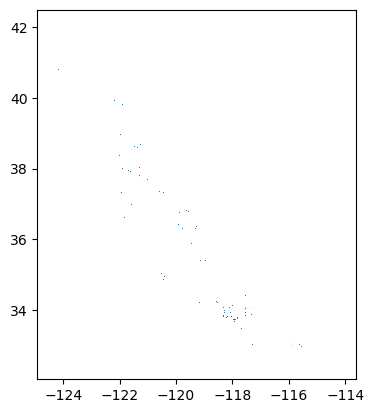

In [7]:
buildings.plot()

## Google's Project Sunroof 

In [13]:
# read in Google's Project Sunroof Data
sunroof_data_path = '../../../rooftop_solar_potential_data/project-sunroof-census_tract.csv'

sunroof_data = pd.read_csv(sunroof_data_path)

sunroof_data.head(3)


,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,1001020100,Alabama,32.505161,32.449730,-86.475128,-86.510422,32.477184,-86.490082,1095.65,591.0,...,6.735739e+05,3.744787e+06,2.558342e+06,2.776739e+06,2.567009e+06,14854.402856,1.232045e+07,"[[0,76],[5,163],[10,136],[15,78],[20,52],[25,2...",7325.568357,0.0
1,1001020200,Alabama,32.489342,32.456120,-86.465378,-86.481270,32.474255,-86.473381,1095.65,718.0,...,1.354248e+06,4.702247e+06,2.993705e+06,2.978384e+06,6.819697e+06,13564.145190,1.884828e+07,"[[0,122],[5,200],[10,168],[15,89],[20,46],[25,...",11206.925804,0.0
2,1001020300,Alabama,32.491909,32.459209,-86.450684,-86.470871,32.475426,-86.460190,1095.65,1121.0,...,2.010001e+06,7.390340e+06,3.998881e+06,4.096211e+06,8.226100e+06,12725.930640,2.572153e+07,"[[0,167],[5,363],[10,258],[15,150],[20,61],[25...",15293.664803,1.0


In [16]:
# isolate for CA observations
sunroof_ca = sunroof_data.loc[sunroof_data['state_name'] == 'California']

sunroof_ca

,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
2534,6001400100,California,37.885250,37.849960,-122.212379,-122.246674,37.867596,-122.231903,1229.958203,1045.0,...,1.528015e+06,5.757000e+06,4.225887e+06,5.626865e+06,5.968850e+06,15631.896777,2.310662e+07,"[[0,160],[5,299],[10,236],[15,128],[20,66],[25...",6299.580778,143.0
2535,6001400200,California,37.852020,37.842609,-122.241913,-122.257919,37.848171,-122.249580,1229.950000,605.0,...,5.049382e+05,2.693077e+06,9.184484e+05,2.181586e+06,3.294712e+06,10733.276013,9.592760e+06,"[[0,131],[5,269],[10,133],[15,42],[20,5],[25,3...",2615.284106,38.0
2536,6001400300,California,37.848511,37.834541,-122.243721,-122.265633,37.840599,-122.254440,1229.950000,1517.0,...,1.804763e+06,8.159908e+06,3.770743e+06,4.230930e+06,4.996662e+06,12190.040503,2.296301e+07,"[[0,271],[5,667],[10,386],[15,109],[20,27],[25...",6260.427892,51.0
2537,6001400400,California,37.853580,37.841351,-122.252350,-122.261864,37.848209,-122.257462,1229.950000,1024.0,...,5.388761e+05,4.492272e+06,2.012416e+06,4.198114e+06,3.364350e+06,11281.748889,1.460603e+07,"[[0,227],[5,430],[10,219],[15,86],[20,30],[25,...",3982.056786,47.0
2538,6001400500,California,37.852741,37.844139,-122.260231,-122.269691,37.848518,-122.264740,1229.950000,905.0,...,5.172534e+05,3.005721e+06,1.770487e+06,4.458502e+06,3.075224e+06,11697.889465,1.282719e+07,"[[0,181],[5,374],[10,229],[15,69],[20,17],[25,...",3497.089335,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10520,6115040700,California,39.077759,38.918350,-121.487907,-121.610260,39.017311,-121.553398,1195.950000,1253.0,...,2.818762e+06,1.012165e+07,6.880229e+06,8.635212e+06,8.325822e+06,21321.129810,3.678167e+07,"[[0,40],[5,199],[10,376],[15,317],[20,155],[25...",10027.825631,63.0
10521,6115040800,California,39.081841,38.990639,-121.315849,-121.515831,39.039139,-121.432472,1195.950000,24.0,...,2.593170e+04,2.931309e+04,5.745617e+04,7.432361e+04,1.255567e+06,22713.607031,1.442592e+06,"[[0,4],[5,4],[10,2],[15,4],[20,2],[25,2],[30,1...",393.295286,2.0
10522,6115040901,California,39.234692,39.034618,-121.279533,-121.583397,39.145393,-121.402588,1195.950000,589.0,...,1.585299e+06,4.138617e+06,3.487827e+06,3.669715e+06,6.280834e+06,19825.987695,1.916229e+07,"[[0,68],[5,115],[10,134],[15,104],[20,51],[25,...",5224.235168,16.0
10523,6115041000,California,39.367668,39.158520,-121.200150,-121.636368,39.267548,-121.441299,NaN,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,18043.688354,NaN,"[[0,21],[5,27],[10,22],[15,13],[20,13],[25,4],...",0.000000,0.0


## Global Horizontal Irradiance Annual GHI 2018, NREL

In [9]:
import rasterio

In [12]:
ghi_path = '../../../rooftop_solar_potential_data/nsrdbv3_ghi/Annual GHI/nsrdb3_ghi.tif'

ghi = rasterio.open(ghi_path)

ghi

# selecting the initial layer
array = ghi.read(1)

array.shape

(2025, 3940)

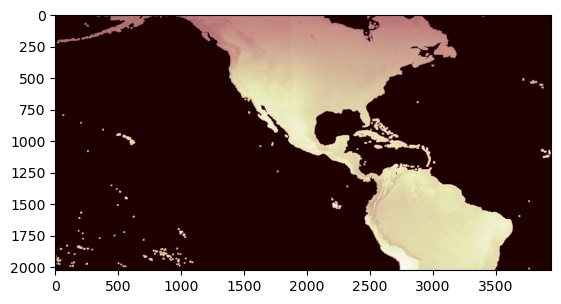

In [14]:
from matplotlib import pyplot

pyplot.imshow(array, cmap='pink')

pyplot.show()  

## Annual Technology Baseline